In [3]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.colorbar as cb
from scipy import signal
import numpy as np
from utilities import cwt
from utilities import DAS
import datetime


In [6]:

file_path = './Data/2023p152354/south30_50Hz_UTC_20230226_085600.122.h5'
#earthquake and car sample ? 
file_path2 = './Data/2023p152354/south30_50Hz_UTC_20230226_085500.122.h5'



DAS_data2, start_time2 = DAS.open_H5_file(file_path)

DAS_data, start_time = DAS.open_H5_file(file_path2)
print(start_time2)
print(isinstance(DAS_data, np.ndarray))
#DAS data is subsampled to everyother channel
print(DAS_data.shape)

f_in = h5py.File(file_path, 'r')
key = list(f_in.keys())

DAS_data = f_in['DAS'][:]
length = DAS_data.shape[1]
print(f'das data has origional length {length}')
DAS_data = DAS_data[:, 81:]
DAS_data = DAS_data[:,0:length]


2023-02-26 08:56:00.122000
True
(3000, 3704)
das data has origional length 7488


(3000, 7407)


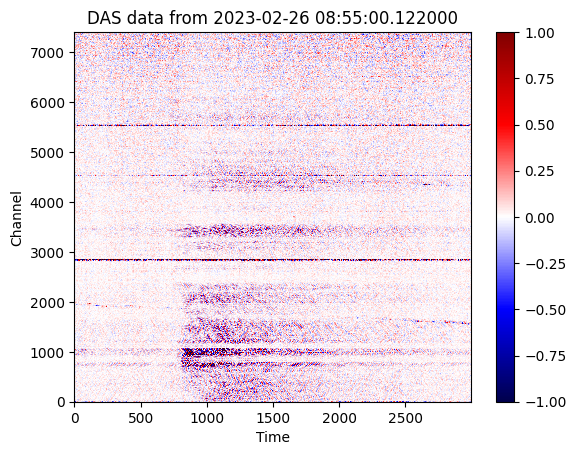

In [5]:
vPlot =1

plt.imshow(DAS_data.T / DAS_data.std(axis=1), vmin=-vPlot, vmax=vPlot, cmap='seismic', aspect='auto', origin='lower')
plt.xlabel("Time")
plt.ylabel("Channel")
plt.title(f'DAS data from {start_time}')

plt.colorbar()
print(DAS_data.shape)


In [20]:


w0 = 8 
dt = 0.02
dj =.5
n_samples = len(DAS_data)
scales = cwt.get_scales(dt, dj, w0, n_samples)

transform = cwt.cwt_time_vec(DAS_data, scales, w0, dt)

/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering/Code/utilities/cwt.py:35: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  multiplied = wavelet.T * fft_signal[None,:, :]


In [21]:
transform.shape
transform = transform.permute(1, 2,0)
transform.shape

torch.Size([3704, 3000, 33])

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_72338/1365571316.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


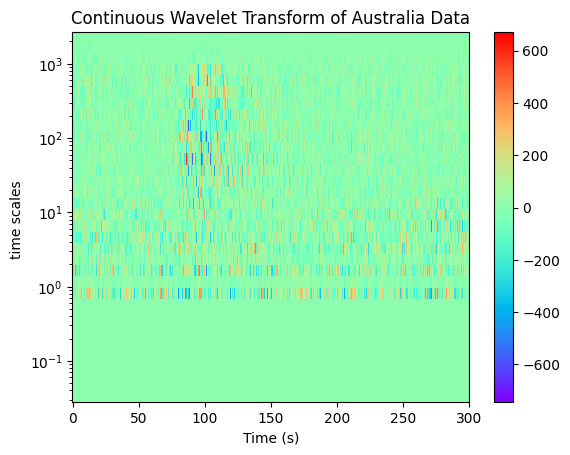

In [22]:
time_line = np.linspace(0, 300, 3000)
fig, axs = plt.subplots()
display_transform = transform[300,:,:].real

pcm = axs.pcolormesh(time_line, scales[::-1], display_transform.T, shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("time scales ")
axs.set_title("Continuous Wavelet Transform of Australia Data")
fig.colorbar(pcm, ax=axs)
fig.show()

In [23]:
inverse_with_mute = np.zeros((transform.shape[0], transform.shape[1]))
inverse_with_less_mute = np.zeros((transform.shape[0], transform.shape[1]))
inverse = np.zeros((transform.shape[0], transform.shape[1]))
print(transform.shape)
mute = np.ones(scales.shape)
less_mute = np.ones(scales.shape)
n_muted_scale = 2
n_less_muted_scales =1
mute[:n_muted_scale] = 0.001
less_mute[:n_less_muted_scales] = 0.001
mute = scales * mute
less_mute= scales * less_mute
#loop over channels of transformed data 
for i in range(transform.shape[0]):
    #check if this channel was assigned to the problem cluster 
    inverse_with_mute[i,:] = cwt.inverse_cwt(transform[i, :, :scales.shape[0]].T, mute, dj, dt, w0)
    #channels that are not part of the problem cluster
    inverse[i,:] = cwt.inverse_cwt(transform[i,:,:scales.shape[0]].T, scales, dj, dt, w0)
    inverse_with_less_mute[i,:] = cwt.inverse_cwt(transform[i,:,:scales.shape[0]].T, less_mute, dj, dt, w0)
print(inverse.shape)

torch.Size([3704, 3000, 33])


/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_72338/233292299.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  inverse_with_mute[i,:] = cwt.inverse_cwt(transform[i, :, :scales.shape[0]].T, mute, dj, dt, w0)
/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_72338/233292299.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  inverse[i,:] = cwt.inverse_cwt(transform[i,:,:scales.shape[0]].T, scales, dj, dt, w0)
/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_72338/233292299.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  inverse_with_less_mute[i,:] = cwt.inverse_cwt(transform[i,:,:scales.shape[0]].T, less_mute, dj, dt, w0)


(3704, 3000)


(3704, 3000)


/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_72338/3656250232.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


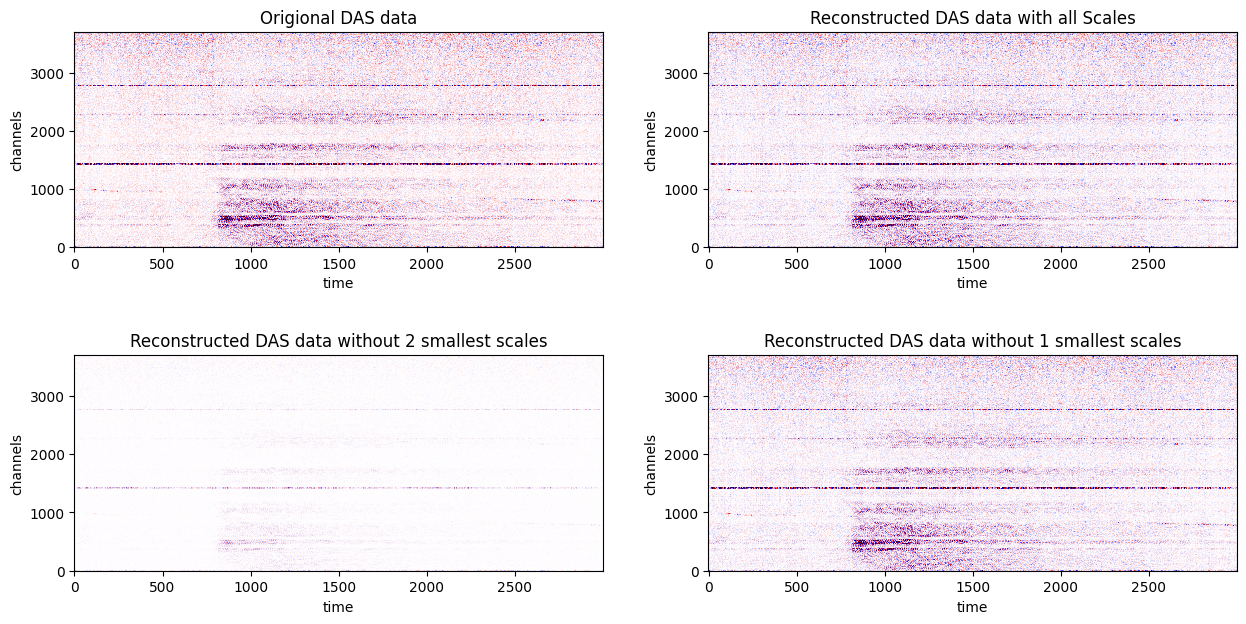

In [24]:
print(inverse_with_less_mute.shape)
vPlot = 1
fig , ((ax11, ax12), (ax21, ax22))=  plt.subplots(nrows=2, ncols=2, figsize =(15, 7))
ax11.set_title("Origional DAS data")
ax11.imshow(DAS_data.T / DAS_data.std(axis=1), vmin=-vPlot, vmax=vPlot, cmap='seismic', aspect='auto', origin='lower')
ax11.set_xlabel("time")
ax11.set_ylabel("channels")

ax12.set_title("Reconstructed DAS data with all Scales")
ax12.imshow(inverse / inverse.std(axis=0), vmin=-vPlot, vmax=vPlot, cmap='seismic', aspect='auto', origin='lower')
ax12.set_xlabel("time")
ax12.set_ylabel("channels")

ax21.imshow(inverse_with_mute / inverse_with_mute.std(axis=0), vmin=-vPlot, vmax=vPlot, cmap='seismic', aspect='auto', origin='lower')
ax21.set_title(f'Reconstructed DAS data without {n_muted_scale} smallest scales')
ax21.set_xlabel("time")
ax21.set_ylabel("channels")

ax22.imshow(inverse_with_less_mute / inverse_with_less_mute.std(axis=0), vmin=-vPlot, vmax=vPlot, cmap='seismic', aspect='auto', origin='lower')
ax22.set_title(f'Reconstructed DAS data without {n_less_muted_scales} smallest scales')
ax22.set_xlabel("time")
ax22.set_ylabel("channels")

plt.subplots_adjust(hspace=.5)
plt.xlabel("time")
plt.ylabel("channels")
fig.show()